In [1]:
import networkx as nx
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

#### utils

In [2]:
midas2id = {
    "appreciation": 0, "command": 1, "comment": 2,"complaint": 3,
    "dev_command": 4, "neg_answer": 5, "open_question_factual": 6,
    "open_question_opinion": 7, "opinion": 8, "other_answers": 9,
    "pos_answer": 10, "statement": 11, "yes_no_question": 12,
}

id2midas = [key for key in midas2id]

In [3]:
def extract_midas(dataset: dict) -> list:
    midas_by_dialog = list()
    
    for key in dataset:
        midas = list()
        
        for ut in dataset[key]:
            midas.append([max(sent, key=sent.get) for sent in ut['midas']])
        
        midas_by_dialog.append(midas)    
        
    return midas_by_dialog

def extract_midas_by_proba(dataset: dict) -> list:
    dialogs = list()
    for d in dataset.values():
        utterances = list()
        for ut in d:
            context = np.zeros((len(ut['midas']), 13))
            for i, midas in enumerate(ut['midas']):
                context[i,:] = list(midas.values())
            
            context = np.max(context, axis=0)
            context = id2midas[np.argmax(context)]
            first_ut = max(ut['midas'][0], key=ut['midas'][0].get)
            utterances.append((context, first_ut))
            
        dialogs.append(utterances)
            
    return dialogs

def get_top_edges(cnt: Counter, top_n=1) -> dict():
    top_edges = {}

    for edge, qty in cnt.most_common():
        source = edge[0]

        if source not in top_edges:
            top_edges[source] = []

        if len(top_edges[source]) >= top_n:
            continue

        top_edges[source].append(edge)
        
    return top_edges

def extract_edges(midas_by_dialog_and_utter: list) -> list:
    all_edges = list()
    
    for d in midas_by_dialog_and_utter:
        dial_edges = list()
        for ut in d:
            dial_edges.append(ut[0])
            
            if len(ut) > 1:
                dial_edges.append(ut[-1])
        
        all_edges.append(dial_edges[1:])
        
    return all_edges

def extract_edges_proba(midas_by_dialog_and_utter: list) -> list:
    all_edges = list()
    
    for d in midas_by_dialog_and_utter:
        dial_edges = list()
        context = d[0][0]
        
        for i in range(1, len(d)):
            next_ut = d[i][1]
            
            all_edges.append((context, next_ut))
            
            context = d[i][0]
            
    return all_edges


def extract_edges_proba_v2(midas_by_dialog_and_utter: list) -> list:
    all_edges = list()
    
    for d in midas_by_dialog_and_utter:
        d_edges = list()
        for i in range(len(d)):
            d_edges.append(d[i][0])
        all_edges.append(d_edges)
        
    return all_edges

def count_edges(edges: list) -> Counter:
    edge_cnt = Counter()

    for d in edges:
        for i in range(1, len(d)):
            edge_cnt.update([(d[i-1], d[i])])
            
    return edge_cnt

## main

In [4]:
with open('data/topical_chat_annotated_v3.json', 'r', encoding='utf8') as f:
    topical = json.load(f)
    
with open('data/daily_dialogue_annotated_v3.json', 'r', encoding='utf8') as f:
    daily = json.load(f)

In [7]:
len(daily), len(topical)

(12376, 8628)

In [6]:
daily_midas = extract_midas(daily)
topical_midas = extract_midas(topical)
daily_midas_proba = extract_midas_by_proba(daily)
topical_midas_proba = extract_midas_by_proba(topical)

In [8]:
len(daily_midas), len(topical_midas), len(daily_midas_proba), len(topical_midas_proba)

(12376, 8628, 12376, 8628)

In [9]:
daily_midas_proba[0]

[('open_question_factual', 'comment'),
 ('statement', 'statement'),
 ('open_question_opinion', 'complaint'),
 ('statement', 'statement'),
 ('statement', 'statement'),
 ('complaint', 'complaint'),
 ('statement', 'statement'),
 ('opinion', 'opinion'),
 ('yes_no_question', 'yes_no_question'),
 ('statement', 'statement'),
 ('statement', 'statement')]

### one2one

In [10]:
daily_edges = extract_edges(daily_midas)
daily_cnt = count_edges(daily_edges)

topical_edges = extract_edges(topical_midas)
topical_cnt = count_edges(topical_edges)
        
daily_edges_proba = extract_edges_proba(daily_midas_proba)
topical_edges_proba = extract_edges_proba(topical_midas_proba)
daily_proba_cnt = Counter(daily_edges_proba)
topical_proba_cnt = Counter(topical_edges_proba)

daily_edges_proba_v2 = extract_edges_proba_v2(daily_midas_proba)
topical_edges_proba_v2 = extract_edges_proba_v2(topical_midas_proba)
daily_proba_cnt_v2 = count_edges(daily_edges_proba_v2)
topical_proba_cnt_v2 = count_edges(topical_edges_proba_v2)

print(daily_cnt.most_common(10))
print("\n")
print(daily_proba_cnt.most_common(10))
print("\n")
print(daily_proba_cnt_v2.most_common(10))
print("\n\n\n")
print(topical_cnt.most_common(10))
print("\n")
print(topical_proba_cnt.most_common(10))
print("\n")
print(topical_proba_cnt_v2.most_common(10))
print("\n")

[(('statement', 'statement'), 17546), (('statement', 'opinion'), 8232), (('opinion', 'opinion'), 7816), (('opinion', 'statement'), 6931), (('open_question_factual', 'statement'), 6429), (('statement', 'yes_no_question'), 5067), (('statement', 'open_question_factual'), 4094), (('yes_no_question', 'statement'), 4078), (('pos_answer', 'statement'), 2701), (('yes_no_question', 'pos_answer'), 2663)]


[(('statement', 'statement'), 12194), (('open_question_factual', 'statement'), 6504), (('statement', 'opinion'), 6468), (('opinion', 'opinion'), 4737), (('yes_no_question', 'statement'), 3783), (('opinion', 'statement'), 3714), (('statement', 'yes_no_question'), 3499), (('statement', 'open_question_factual'), 3307), (('yes_no_question', 'pos_answer'), 2494), (('statement', 'comment'), 2334)]


[(('statement', 'statement'), 13965), (('open_question_factual', 'statement'), 6796), (('statement', 'opinion'), 5915), (('opinion', 'opinion'), 4664), (('yes_no_question', 'statement'), 4522), (('opinio

In [11]:
daily_top_edges = get_top_edges(daily_cnt, top_n=3)
topical_top_edges = get_top_edges(topical_cnt, top_n=3)
daily_proba_top_edges = get_top_edges(daily_proba_cnt, top_n=3)
topical_proba_top_edges = get_top_edges(topical_proba_cnt, top_n=3)
daily_proba_top_edges_v2 = get_top_edges(daily_proba_cnt_v2, top_n=3)
topical_proba_top_edges_v2 = get_top_edges(topical_proba_cnt_v2, top_n=3)

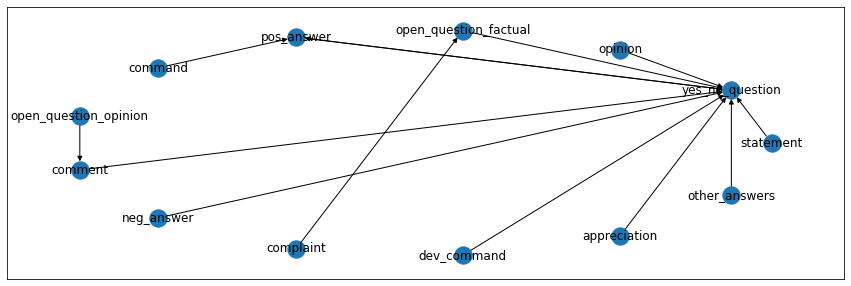

In [12]:
edges = [edge for source in list(daily_top_edges.values()) for edge in source if edge[1] not in ['opinion', 'statement']]
G = nx.DiGraph(edges)
plt.figure(3,figsize=(15,5)) 
layout = nx.circular_layout(G)
nx.draw_networkx(G, pos=layout)
plt.show()

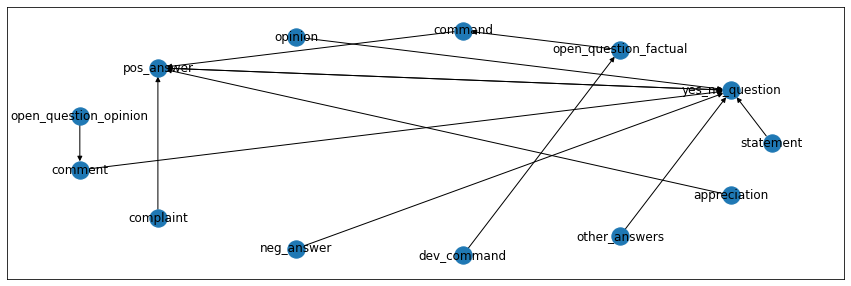

In [13]:
edges = [edge for source in list(daily_proba_top_edges.values()) for edge in source if edge[1] not in ['opinion', 'statement']]
G = nx.DiGraph(edges)
plt.figure(3,figsize=(15,5)) 
layout = nx.circular_layout(G)
nx.draw_networkx(G, pos=layout)
plt.show()

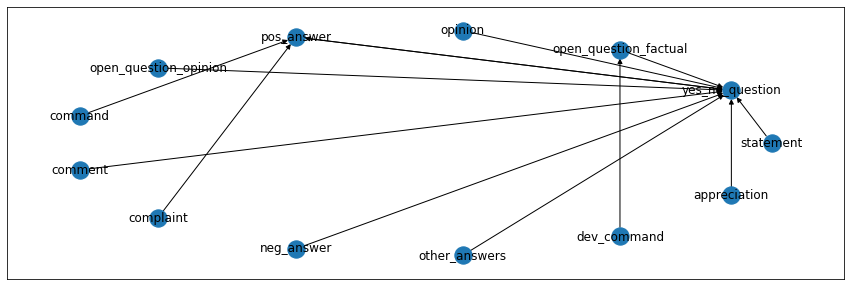

In [14]:
edges = [edge for source in list(daily_proba_top_edges_v2.values()) for edge in source if edge[1] not in ['opinion', 'statement']]
G = nx.DiGraph(edges)
plt.figure(3,figsize=(15,5)) 
layout = nx.circular_layout(G)
nx.draw_networkx(G, pos=layout)
plt.show()

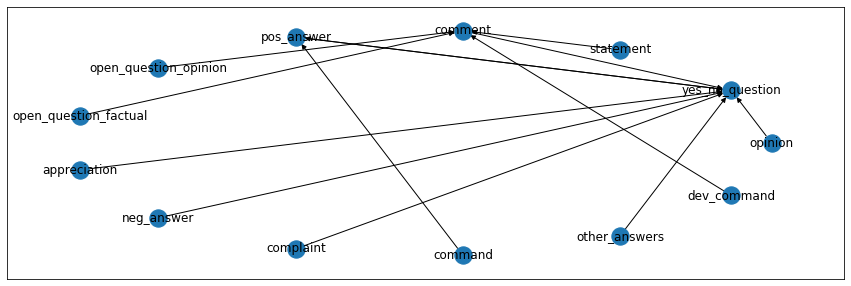

In [15]:
edges = [edge for source in list(topical_top_edges.values()) for edge in source if edge[1] not in ['opinion', 'statement']]
G = nx.DiGraph(edges)
plt.figure(3,figsize=(15,5)) 
layout = nx.circular_layout(G)
nx.draw_networkx(G, pos=layout)
plt.show()

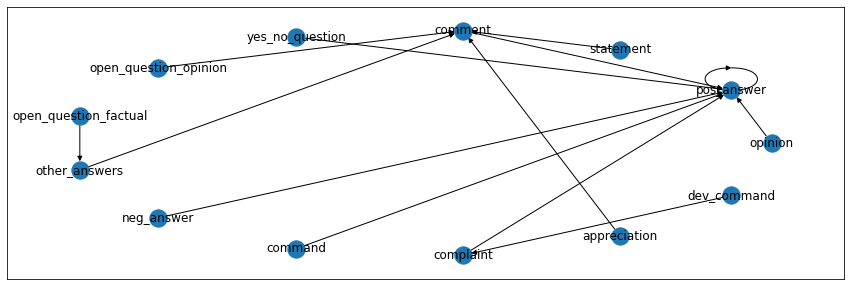

In [16]:
edges = [edge for source in list(topical_proba_top_edges.values()) for edge in source if edge[1] not in ['opinion', 'statement']]
G = nx.DiGraph(edges)
plt.figure(3,figsize=(15,5)) 
layout = nx.circular_layout(G)
nx.draw_networkx(G, pos=layout)
plt.show()

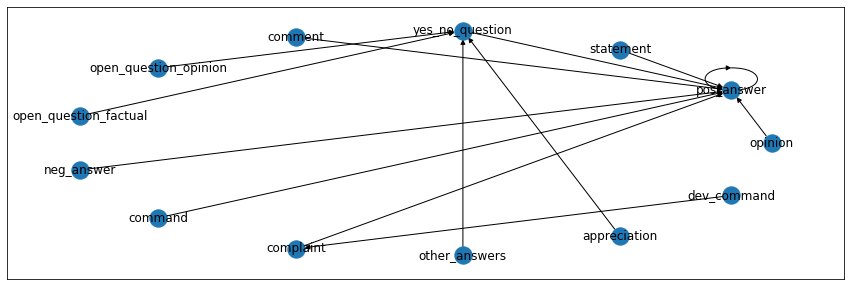

In [23]:
edges = [edge for source in list(topical_proba_top_edges_v2.values()) for edge in source if edge[1] not in ['opinion', 'statement']]
G = nx.DiGraph(edges)
plt.figure(3,figsize=(15,5))
layout = nx.circular_layout(G)
nx.draw_networkx(G, pos=layout)
plt.show()

### dialog flow

In [18]:
daily_edges = extract_edges_proba_v2(daily_midas)
daily_edges = [tuple(d[:4]) for d in daily_edges]
daily_cnt = Counter(daily_edges)
daily_cnt.most_common(10)

[(('statement', 'statement', 'statement', 'statement'), 197),
 (('open_question_factual', 'statement', 'open_question_factual', 'statement'),
  163),
 (('statement', 'statement', 'open_question_factual', 'statement'), 112),
 (('open_question_factual', 'statement', 'statement', 'statement'), 106),
 (('yes_no_question', 'statement', 'open_question_factual', 'statement'), 106),
 (('statement', 'open_question_factual', 'statement', 'statement'), 97),
 (('yes_no_question', 'statement', 'statement', 'statement'), 92),
 (('statement', 'statement', 'statement', 'opinion'), 90),
 (('yes_no_question', 'pos_answer', 'open_question_factual', 'statement'), 84),
 (('statement', 'statement', 'opinion', 'statement'), 79)]

In [19]:
topical_edges = extract_edges_proba_v2(topical_midas)
topical_edges = [tuple(d[:4]) for d in topical_edges]
topical_cnt = Counter(topical_edges)
topical_cnt.most_common(10)

[(('statement', 'statement', 'opinion', 'opinion'), 131),
 (('statement', 'opinion', 'opinion', 'opinion'), 111),
 (('yes_no_question', 'pos_answer', 'opinion', 'opinion'), 110),
 (('statement', 'statement', 'statement', 'statement'), 109),
 (('statement', 'pos_answer', 'opinion', 'opinion'), 104),
 (('statement', 'statement', 'statement', 'opinion'), 103),
 (('yes_no_question', 'opinion', 'opinion', 'opinion'), 101),
 (('statement', 'statement', 'opinion', 'statement'), 89),
 (('yes_no_question', 'statement', 'opinion', 'opinion'), 88),
 (('yes_no_question', 'pos_answer', 'opinion', 'statement'), 87)]

In [20]:
daily_edges = extract_edges_proba_v2(daily_midas)
daily_edges = [tuple(d[:4]) for d in daily_edges]
daily_cnt = Counter(daily_edges)

daily_cnt = [(d, cnt) for d, cnt in daily_cnt.most_common() if len(set(d)) > 2 and cnt > 30]
daily_cnt

[(('yes_no_question', 'statement', 'open_question_factual', 'statement'), 106),
 (('yes_no_question', 'pos_answer', 'open_question_factual', 'statement'), 84),
 (('command', 'statement', 'open_question_factual', 'statement'), 65),
 (('open_question_factual', 'statement', 'yes_no_question', 'statement'), 64),
 (('yes_no_question', 'pos_answer', 'statement', 'statement'), 52),
 (('open_question_opinion', 'statement', 'open_question_factual', 'statement'),
  52),
 (('yes_no_question', 'statement', 'statement', 'opinion'), 46),
 (('open_question_factual', 'statement', 'statement', 'opinion'), 46),
 (('open_question_factual', 'statement', 'open_question_opinion', 'opinion'),
  43),
 (('yes_no_question', 'statement', 'opinion', 'statement'), 43),
 (('open_question_factual', 'statement', 'yes_no_question', 'pos_answer'), 42),
 (('open_question_factual', 'statement', 'opinion', 'statement'), 40),
 (('command', 'statement', 'yes_no_question', 'statement'), 37),
 (('statement', 'open_question_fa

In [21]:
topical_edges = extract_edges_proba_v2(topical_midas)
topical_edges = [tuple(d[:4]) for d in topical_edges]
topical_cnt = Counter(topical_edges)

topical_cnt = [(d, cnt) for d, cnt in topical_cnt.most_common() if len(set(d)) > 2 and cnt > 30]
topical_cnt

[(('yes_no_question', 'pos_answer', 'opinion', 'opinion'), 110),
 (('statement', 'pos_answer', 'opinion', 'opinion'), 104),
 (('yes_no_question', 'statement', 'opinion', 'opinion'), 88),
 (('yes_no_question', 'pos_answer', 'opinion', 'statement'), 87),
 (('yes_no_question', 'pos_answer', 'statement', 'pos_answer'), 83),
 (('yes_no_question', 'statement', 'statement', 'opinion'), 72),
 (('yes_no_question', 'pos_answer', 'statement', 'opinion'), 70),
 (('yes_no_question', 'statement', 'opinion', 'statement'), 70),
 (('yes_no_question', 'pos_answer', 'statement', 'statement'), 68),
 (('yes_no_question', 'opinion', 'opinion', 'statement'), 62),
 (('statement', 'statement', 'pos_answer', 'opinion'), 56),
 (('yes_no_question', 'opinion', 'statement', 'opinion'), 53),
 (('yes_no_question', 'pos_answer', 'opinion', 'pos_answer'), 51),
 (('statement', 'pos_answer', 'opinion', 'statement'), 51),
 (('yes_no_question', 'neg_answer', 'opinion', 'opinion'), 49),
 (('statement', 'statement', 'opinion